In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

#### Let's load the Nashville zipcode data and look at the first few rows
- geopandas reads files with the `read_file()` method
- The zipcode data was downloaded from https://data.nashville.gov/General-Government/Zip-Codes/u7r5-bpku


In [3]:
zipcodes = gpd.read_file('../data/zipcodes.geojson')
print(zipcodes.crs)
zipcodes.head( )

epsg:4326


,zip,objectid,po_name,shape_stlength,shape_starea,geometry
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ..."
1,37216,3,NASHVILLE,75820.997821400058,188884682.28344727,"MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ..."
2,37204,9,NASHVILLE,93180.292250425613,200664795.51708984,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ..."
3,37027,11,BRENTWOOD,159760.6942933173,174978422.04101562,"MULTIPOLYGON (((-86.81258 36.06319, -86.81263 ..."
4,37064,18,FRANKLIN,28995.828320601937,46969608.005737305,"MULTIPOLYGON (((-87.02197 36.01200, -87.02140 ..."


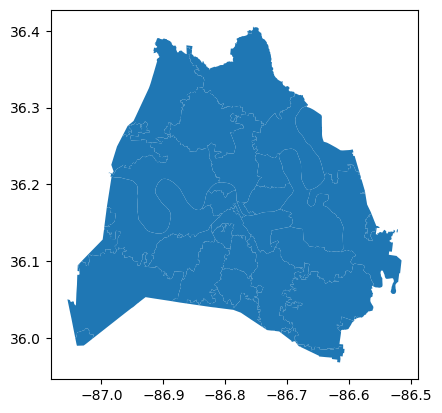

In [4]:
zipcodes.plot();

#### Add information and styling 
- set the `column =` to a column in the GeoDataFrame to color by routes
- change the [colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) 
- pass in keywords to tweak the legend created by `matplotib`

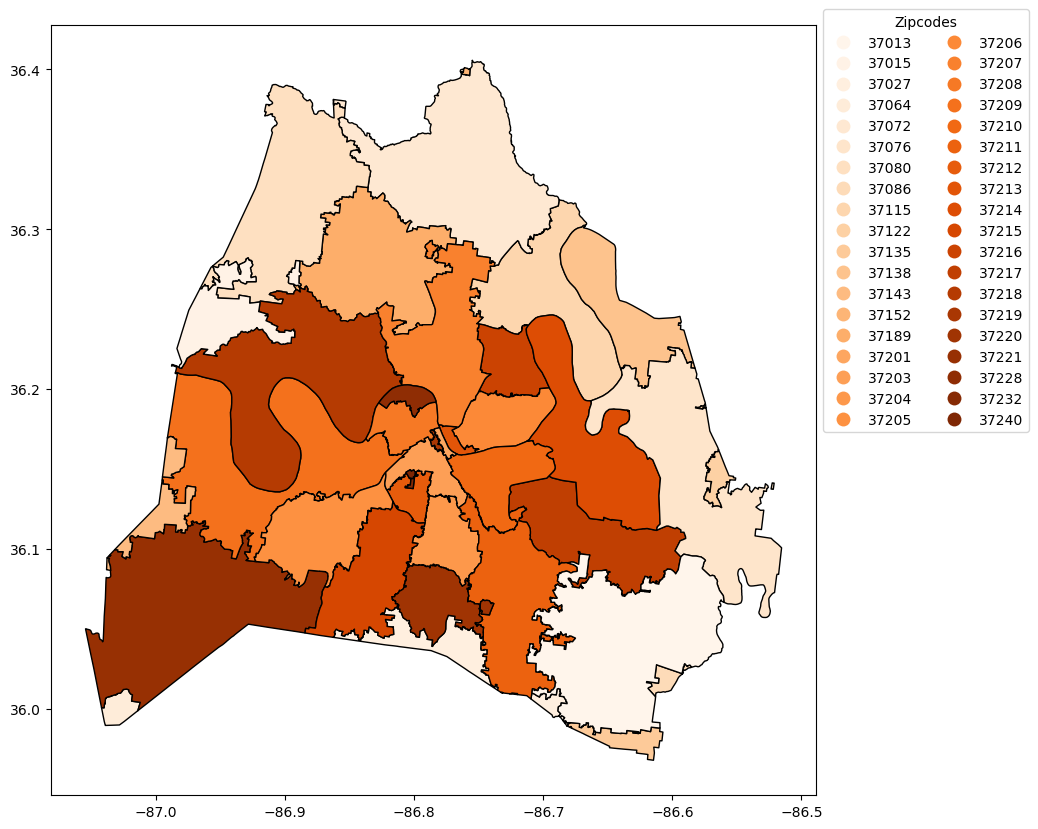

In [5]:
#geopandas handles legend styling if you pass a dict of keywords

leg_kwds = {'title': 'Zipcodes', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 2}

zipcodes.plot(column = 'zip', figsize=(10, 10),
              edgecolor = 'black',
              legend = True, legend_kwds = leg_kwds, 
              cmap = 'Oranges')
plt.show()

there is no geometry column, so it's not a geodata frame, and it needs grs.
in the beginning we brought in point
we can use lat and long to make a point column

In [10]:
bus_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2524 entries, 0 to 2523
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   stop      2524 non-null   object 
 1   route     2524 non-null   object 
 2   location  2524 non-null   object 
 3   lat       2524 non-null   float64
 4   lng       2524 non-null   float64
dtypes: float64(2), object(3)
memory usage: 98.7+ KB


In [11]:
bus_stops.apply(lambda x: Point((float(x.lng), float(x.lat))), axis = 1)

0               POINT (-86.816722 36.236249)
1               POINT (-86.780897 36.142642)
2               POINT (-86.672004 36.105615)
3               POINT (-86.795609 36.137623)
4               POINT (-86.804242 36.175944)
                        ...                 
2519            POINT (-86.809189 36.104296)
2520    POINT (-86.77561900000001 36.110228)
2521            POINT (-86.804974 36.180257)
2522            POINT (-86.757368 36.180416)
2523    POINT (-86.76557200000001 36.150003)
Length: 2524, dtype: object

axis = 1 means it's going to go row by row

#### In order to spatially join the bus stops with the zipcodes, you will need to create a GeoDataFrame of bus stops
- First create a geometry column that is a `Point` datatype

In [12]:
bus_stops['geometry'] = bus_stops.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)
bus_stops.head(3)

,stop,route,location,lat,lng,geometry
0,GREEN LN & WHITES CREEK PIKE WB,GOLDEN VALLEY,"(36.236249, -86.816722)",36.236249,-86.816722,POINT (-86.816722 36.236249)
1,_ 9TH AVE S & EDGEHILL AVE SB,8TH AVENUE SOUTH,"(36.142642, -86.780897)",36.142642,-86.780897,POINT (-86.780897 36.142642)
2,DONELSON/DELL STATION OUTBOUND,MURFREESBORO PIKE,"(36.105615, -86.672004)",36.105615,-86.672004,POINT (-86.672004 36.105615)


#### Now that the bus stops data has a geometry field, you can use it to build a GeoDataFrame 
- you want the CRS for the bus stops to match the CRS in the zipcodes GeoDataFrame 
CRS = coordinate reference system

In [13]:
zipcodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### The `GeoDataFrame()` constructor needs 3 parameters:
 - a DataFrame
 - a coordinate reference system
 - a geometry

In [14]:
bus_geo = gpd.GeoDataFrame(bus_stops, 
                           crs = zipcodes.crs, 
                           geometry = bus_stops['geometry'])

In [15]:
type(bus_geo)

geopandas.geodataframe.GeoDataFrame

#### Now you are ready to combine bus stops and zipcodes with a spatial join
- first a little clean up for the zipcodes
    - just keep the zip, po_name, and geometry columns
- then construct the join 
    - keep in mind that you want to find the bus stops within a zip code polygon
    - the geometry for the new (combined) GeoDataFrame comes from the left GeoDataFrame

In [16]:
zipcodes = zipcodes[['zip', 'po_name', 'geometry']]
zipcodes

,zip,po_name,geometry
0,37115,MADISON,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ..."
1,37216,NASHVILLE,"MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ..."
2,37204,NASHVILLE,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ..."
3,37027,BRENTWOOD,"MULTIPOLYGON (((-86.81258 36.06319, -86.81263 ..."
4,37064,FRANKLIN,"MULTIPOLYGON (((-87.02197 36.01200, -87.02140 ..."
5,37143,PEGRAM,"MULTIPOLYGON (((-87.03553 36.08659, -87.03556 ..."
6,37080,JOELTON,"MULTIPOLYGON (((-86.86263 36.37811, -86.86264 ..."
7,37221,NASHVILLE,"MULTIPOLYGON (((-86.97084 36.11644, -86.97084 ..."
8,37072,GOODLETTSVILLE,"MULTIPOLYGON (((-86.75361 36.40428, -86.75354 ..."
9,37212,NASHVILLE,"MULTIPOLYGON (((-86.80790 36.14643, -86.80605 ..."


This is a geospatial join:  need to use predicate instead of op in the current version
Whatever is on the left is the geometry that will be kept

In [17]:
stops_by_zip = gpd.sjoin(bus_geo, zipcodes, op = 'within')

In [18]:
stops_by_zip.head()

,stop,route,location,lat,lng,geometry,index_right,zip,po_name
0,GREEN LN & WHITES CREEK PIKE WB,GOLDEN VALLEY,"(36.236249, -86.816722)",36.236249,-86.816722,POINT (-86.81672 36.23625),18,37189,WHITES CREEK
976,OLD HICKORY BLVD & COBBLESTONE CREEK DR EB,HICKORY HILLS,"(36.278199, -86.789015)",36.278199,-86.789015,POINT (-86.78902 36.27820),18,37189,WHITES CREEK
1668,WHITES CREEK HIGH SCHOOL,HICKORY HILLS,"(36.276203, -86.819009)",36.276203,-86.819009,POINT (-86.81901 36.27620),18,37189,WHITES CREEK
2161,GREEN LN & KNIGHT DR WB,GOLDEN VALLEY,"(36.236813, -86.803848)",36.236813,-86.803848,POINT (-86.80385 36.23681),18,37189,WHITES CREEK
2483,OLD HICKORY BLVD & COBBLESTONE CREEK DR WB,HICKORY HILLS,"(36.278342, -86.788981)",36.278342,-86.788981,POINT (-86.78898 36.27834),18,37189,WHITES CREEK


#### Now that the data is joined spatially you can count the bus stops by zip code  and see how many stops are within each polygon 
- using the `value_counts()` method

will count how many times the zipcodes appear in the dataframe, and each row is a busstop, so that also tells us how many busstops (observations)


In [19]:
stops_by_zip['zip'].value_counts()

37207    272
37203    237
37206    205
37211    174
37208    165
37209    149
37210    141
37217    121
37115    106
37013    103
37204     90
37216     88
37214     87
37212     86
37218     83
37215     53
37205     52
37076     50
37219     48
37221     45
37201     36
37138     32
37228     27
37213     10
37027      9
37072      7
37189      5
37240      4
Name: zip, dtype: int64

#### Let's take a closer look at the 272 bus stops in the 37207 zip code
- filter the stops_by_zip data to just get bus stops in 37207
- filter the zip code geodataframe to just the polygon (row) for 37207


In [20]:
stops_in_37207 = stops_by_zip.loc[stops_by_zip['zip'] == '37207']
stops_in_37207.shape

(272, 9)

In [21]:
polygon37207 = zipcodes.loc[zipcodes['zip'] == '37207']
polygon37207.shape

(2, 3)

In [38]:
type(polygon37207)

geopandas.geodataframe.GeoDataFrame

there are two zipcode entries for two zipcodes because there are non continguous or continous zipcodes, where there is a a gap in the area, but it's the same zipcode

#### Now plot these two together
- first plot the polygons for 37207 and make them light green
- next plot the points for the bus stops and color them by route

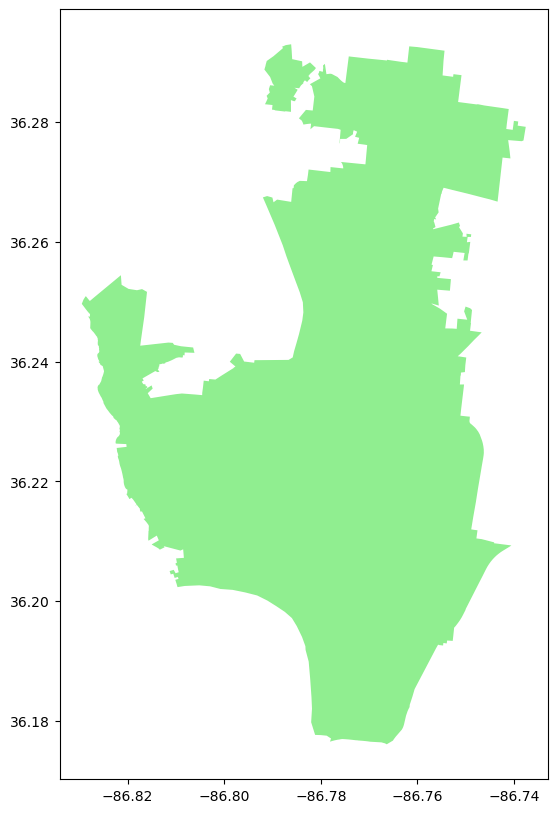

In [22]:
ax = polygon37207.plot(figsize = (8, 10), color = 'lightgreen')

Below ax on left is a keyword set in the above line, ax on the right is a variable
column allows you to color code by grouping values in that column

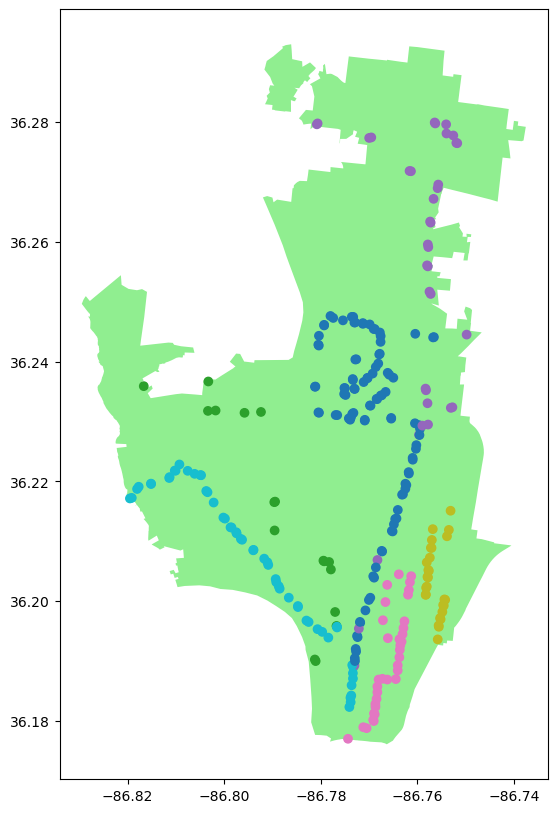

In [37]:
#fig, ax = matplotlib.subplots()
ax = polygon37207.plot(figsize = (8, 10), color = 'lightgreen')
stops_in_37207.plot( ax = ax, column = 'route');
plt.show();

#### We're getting there! It would be helpful to have streets, though wouldn't it? We can add a street map with the folium package.

#### folium maps require a center point for the street map. 
- Make use of a GeoSeries attribute (.centroid) which gives the center of a polygon
- Since there are two polygons which should we use?

Choose a larger polygon

In [33]:
polygon37207.geometry.centroid

C:\Users\houxu\AppData\Local\Temp\ipykernel_45608\3792774199.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon37207.geometry.centroid


19    POINT (-86.78726 36.28724)
42    POINT (-86.77677 36.23245)
dtype: geometry

In [34]:
#find the center of the larger (more southern) polygon and look at it
center = polygon37207.geometry.centroid[42]
print(center)

POINT (-86.77676762469858 36.23245257407244)


C:\Users\houxu\AppData\Local\Temp\ipykernel_45608\3995710814.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = polygon37207.geometry.centroid[42]


#### Folium requires a location point as an array 
- with *latitude* first
- but shapely Points have *longitude* first 

Need to flip lat & long

print(center)

In [35]:
# reverse the order when constructing the array for folium location
area_center = [center.y, center.x]

# check the order of area_center, the location for our folium map
print(area_center)

[36.23245257407244, -86.77676762469858]


this is a list instead of a point

#### To create a folium map just call the folium `Map()` constructor
- `location` is the only argument required by the constructor
    - Set `area_center` as the `location` of the folium map. 
- `zoom_start` is an optional argument 
    - A setting of 12 should get us nice and close

In [36]:
#create our map of Nashville Zip Code 37207 and show it
map_37207 = folium.Map(location =  area_center, zoom_start = 12)
map_37207

zoom start try different numbers and see what makes sense

#### Next, let's add our 37207 polygon and bus stop markers.

#### `itterows()` is a generator that iterates through the rows of a DataFrame and returns a tuple with the row id and row values. 
- Below, we are printing the row values for the first 3 row as we iterate through the GeoDataFrame of bus stops in 37207. 
- This idea will be helpful for creating our markers!

In [28]:
i = 0
for row_index, row_values in stops_in_37207.iterrows():
    if i <3: 
        print('index is', row_index)
        print('values are:')
        print(' ')
        print(row_values)
        print('------------------------- ')
        i+=1

index is 9
values are:
 
stop           DOVERSIDE DR & MOORWOOD DR EB
route                         DICKERSON ROAD
location             (36.240342, -86.772854)
lat                                36.240342
lng                               -86.772854
geometry        POINT (-86.772854 36.240342)
index_right                               42
zip                                    37207
po_name                            NASHVILLE
Name: 9, dtype: object
------------------------- 
index is 11
values are:
 
stop           ROWAN DR & BUENA VISTA PIKE SB
route                            WHITES CREEK
location               (36.21714, -86.819509)
lat                                  36.21714
lng                                -86.819509
geometry          POINT (-86.819509 36.21714)
index_right                                42
zip                                     37207
po_name                             NASHVILLE
Name: 11, dtype: object
------------------------- 
index is 17
values are:
 
sto

#### Create map_37207 again with additional features:
- add the zipcode area outline (polygon_37207)
- iterate through the stops_in_37207 to
    - create location from each lat and lng
    - create a popup from the stop column
    - build a marker from each location and popup
    - add the marker to  `map_37207`
- display `map_37207`

fa=font awesome for markers

In [29]:
#draw our zip code area: 37207
map_37207 = folium.Map(location =  area_center, zoom_start = 12)

folium.GeoJson(polygon37207).add_to(map_37207)

#iterate through stops_in_37207 to create locations and markers 
#for each bus stop
#remember for Folium locations, lat is listed first!!

for row_index, row_values in stops_in_37207.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['route'])
    icon=folium.Icon(color="red",icon="bus", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop, icon = icon) 

    marker.add_to(map_37207)
map_37207.save('../maps/map37207.html')

#display our map
map_37207

#### If you have a lot of markers, you might want to use marker clusters
- Folium has `MarkerCluster()` and `FastMarkerCluster()`
- Construct a `MarkerCluster()` 
    - construct a `MarkerCluster()` and `.add_to()` the map
    - when you loop through the data and create markers add those to the marker cluster
- Construct a `FastMarkerCluster()` by passing a list of locations

#### You can save your map as an html file and it will retain the interactive qualities

In [30]:
folium.Map?

In [31]:
cluster_map_37207 = folium.Map(location =  area_center, zoom_start = 12)

#create a marker cluster
marker_cluster = MarkerCluster().add_to(cluster_map_37207)

folium.GeoJson(polygon37207).add_to(cluster_map_37207)

# inside the loop add each marker to the cluster
for row_index, row_values in stops_in_37207.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['route'])
    icon=folium.Icon(color="blue",icon="bus", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

    
#save an interactive HTML map by calling .save()
cluster_map_37207.save('../maps/cluster37207.html')

cluster_map_37207  

In [32]:
#draw our zip code area: 37207
map_37207 = folium.Map(location =  area_center, zoom_start = 12)

folium.GeoJson(polygon37207).add_to(map_37207)

#create a list of locations and pass them to FastMarkerCluster()
locations = stops_in_37207[['lat', 'lng']].values.tolist()
map_37207.add_child(
    FastMarkerCluster(locations)
)



#display our map
map_37207

#### Note that _if_ the crs contains init it needs to be [updated](https://geopandas.org/projections.html) as shown in the cell below
#### zipcodes.geometry.to_crs('EPSG:4326')
##### print(zipcodes.crs)